In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")


import src.utils.setup_figures as figures
import src.utils.basic as utils

### Load Configs

In [3]:
from config import dir_config, main_config, s_probe_path

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


# Try different encodings
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for encoding in encodings:
    try:
        session_metadata = pd.read_csv(Path(processed_dir, "subject_metadata.csv"), index_col=None, encoding=encoding)
        print(f"Successfully read with encoding: {encoding}")
        break
    except UnicodeDecodeError as e:
        print(f"Failed with encoding: {encoding}, error: {e}")

Successfully read with encoding: utf-8


# Load Aggregate data and preprocess trials

In [4]:
aggregate_data = pd.read_csv(Path(raw_dir, "aggregate_data.csv"), index_col=None)

#### Fill out the subject_metadata prior based on aggregate_data

In [5]:
for subject, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
    # find the corresponding row in the aggregate data
    session_data = aggregate_data[(aggregate_data['subject'] == subject) & (aggregate_data['medication'] == medication.lower())]
    prior = np.unique(session_data['prior'])
    prior = prior[prior != 'eq']
    
    # in session_metadata, where subject and medication matches, update the prior
    
    current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == medication)].index
    session_metadata.loc[current_idx, 'prior_condition'] = prior[0]
    session_metadata.loc[current_idx, 'file_name'] = np.unique(session_data['session_name'])[0]    

In [6]:
# Extract the relevant tremor variables that exist in the DataFrame columns
relevant_tremor_vars = [var for var in main_config.categorization.tremor if var in session_metadata.columns]
# Vectorized operation for summing
if relevant_tremor_vars:  
    # take row-wise mean of the tremor variables and store in a new column
    session_metadata['tremor_score'] = session_metadata[relevant_tremor_vars].mean(axis=1)

In [7]:
# save the updated session_metadata to the processed directory

session_metadata.to_csv(Path(processed_dir, "subject_metadata_updated.csv"), index=False)

##### Data rejection

In [8]:
valid_data = aggregate_data[aggregate_data['is_valid'] == 1]
# chose trials with minimum reaction time from main_config
valid_data = valid_data[valid_data['reaction_time'] >= main_config.behavior.min_rt]
valid_data = valid_data[valid_data['prior'] != 'eq']
valid_data['prior_color'].loc[valid_data['prior'] == 'eq'] = None
valid_data['prior_direction'].loc[valid_data['prior'] == 'eq'] = np.NaN

# remove data from subjects listed in main_config.manual_rejection
valid_data = valid_data[~valid_data['subject'].isin(main_config.manual_rejection)]

#### Direction and color conversion to prior condition

In [9]:
# Ensure valid_data is a DataFrame you intend to modify directly
left_prior_idx = valid_data['prior_direction'] == 'left'
right_prior_idx = valid_data['prior_direction'] == 'right'
green_prior_idx = valid_data['prior_color'] == 'green'
red_prior_idx = valid_data['prior_color'] == 'red'

# Renaming directions based on prior direction
valid_data.loc[left_prior_idx, 'target'] = valid_data.loc[left_prior_idx, 'target'].map({'left': 1, 'right': -1})
valid_data.loc[left_prior_idx, 'choice'] = valid_data.loc[left_prior_idx, 'choice'].map({'left': 1, 'right': -1})
valid_data.loc[right_prior_idx, 'target'] = valid_data.loc[right_prior_idx, 'target'].map({'left': -1, 'right': 1})
valid_data.loc[right_prior_idx, 'choice'] = valid_data.loc[right_prior_idx, 'choice'].map({'left': -1, 'right': 1})

# Renaming colors based on prior color
valid_data.loc[green_prior_idx, 'color'] = valid_data.loc[green_prior_idx, 'color'].map({'green': 1, 'red': -1})
valid_data.loc[red_prior_idx, 'color'] = valid_data.loc[red_prior_idx, 'color'].map({'green': -1, 'red': 1})


valid_data['signed_coherence'] = valid_data['coherence'] * valid_data['target']

#### Rejecting sessions based on allowed lapse rates

In [10]:
main_config.behavior.max_lapse_rate

0.1

In [11]:
sessions = valid_data['session_name'].unique()

reject_sessions = []

for session in sessions:
    session_data = valid_data[valid_data['session_name'] == session]
    for color in [-1, 1]:
        coh, psych, model, _, _ = utils.get_psychometric_data(session_data[session_data['color'] == color])
        
        # print(f"Subject: {session} \t\t {model.coefs_['lapse_rate']}, \t{model.coefs_['guess_rate']}")
        if ((model.coefs_['lapse_rate'] > main_config.behavior.max_lapse_rate)  and model.coefs_['guess_rate'] > main_config.behavior.max_lapse_rate):
            reject_sessions.append(session)
            print(f"Subject: {session} rejected due to high lapse rate, \t\t {model.coefs_['lapse_rate']}, \t{model.coefs_['guess_rate']}")
            # print("Rejected")
            continue
    
valid_data = valid_data[~valid_data['session_name'].isin(reject_sessions)]
    

Subject: Brady_AJL_OFFmeds_gr.mat rejected due to high lapse rate, 		 0.2784576054696169, 	0.49999999999747535
Subject: Brady_AJL_ONmeds_rl.mat rejected due to high lapse rate, 		 0.41008957439778326, 	0.2322542419327332
Subject: Brady_AJL_ONmeds_rl.mat rejected due to high lapse rate, 		 0.3391832232868554, 	0.28828141943883984
Subject: Brady_LHO_OFFmeds_rl.mat rejected due to high lapse rate, 		 0.43975425159989573, 	0.2564583614542672
Subject: Brady_LHO_ONmeds_gl.mat rejected due to high lapse rate, 		 0.4361191641622395, 	0.36859451072974164
Subject: Brady_RBA_OFFmeds_gr.mat rejected due to high lapse rate, 		 0.24544604962703553, 	0.11851608276135554
Subject: Brady_RBA_ONmeds_rl.mat rejected due to high lapse rate, 		 0.15734503638708347, 	0.2830447417599696
Subject: Brady_RBA_ONmeds_rl.mat rejected due to high lapse rate, 		 0.14968577462145607, 	0.2503775785914669
Subject: Brady_RDE_OFFmeds_rr.mat rejected due to high lapse rate, 		 0.2553090936071392, 	0.18164766078438516
Subje

In [12]:
# finding subjects who have both on and off medication sessions 
subject_sessions = valid_data.groupby('subject')['medication'].unique()

valid_subjects = []
for subject, sessions in subject_sessions.items():
    if len(sessions) == 2:
        valid_subjects.append(subject)
        
valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]



In [13]:
print(f"Number of subjects: {len(valid_data['subject'].unique())}")
print(valid_subjects)

Number of subjects: 23
['CG', 'COH', 'DP', 'FUR', 'LBR', 'MAR', 'MBY', 'P1', 'P11', 'P12', 'P13', 'P16', 'P18', 'P20', 'P22', 'P23', 'P24', 'P6', 'P9', 'PAM', 'RW', 'SGA', 'SMI']


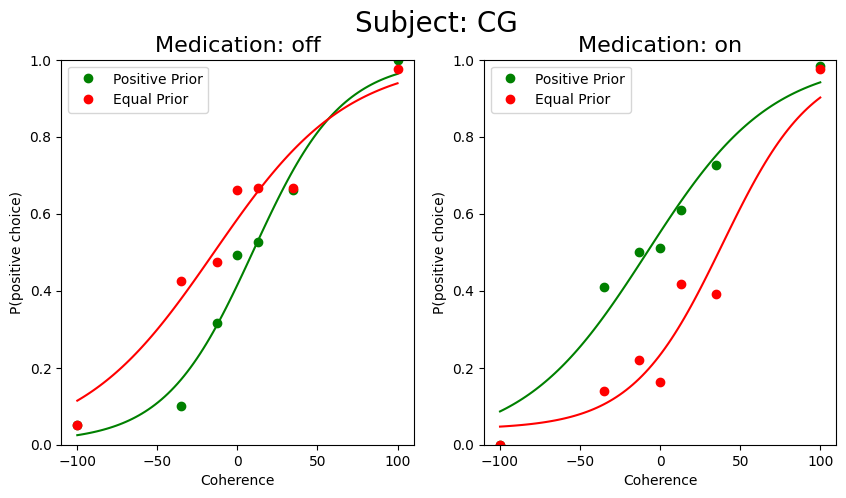

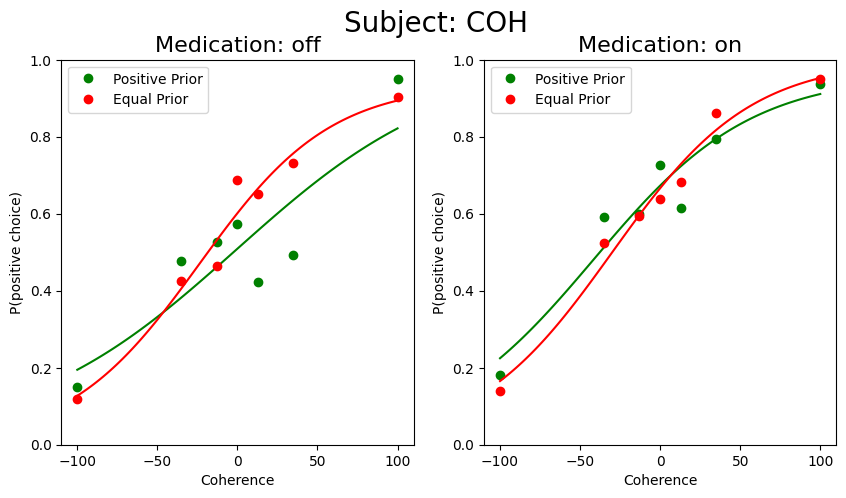

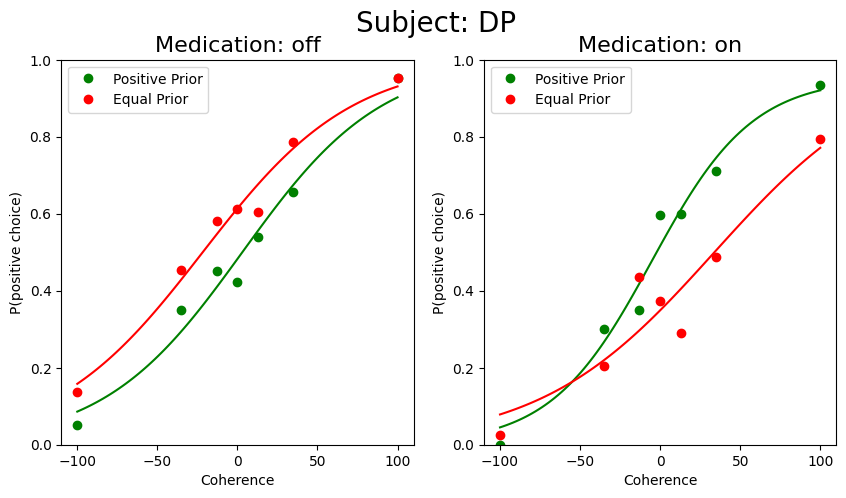

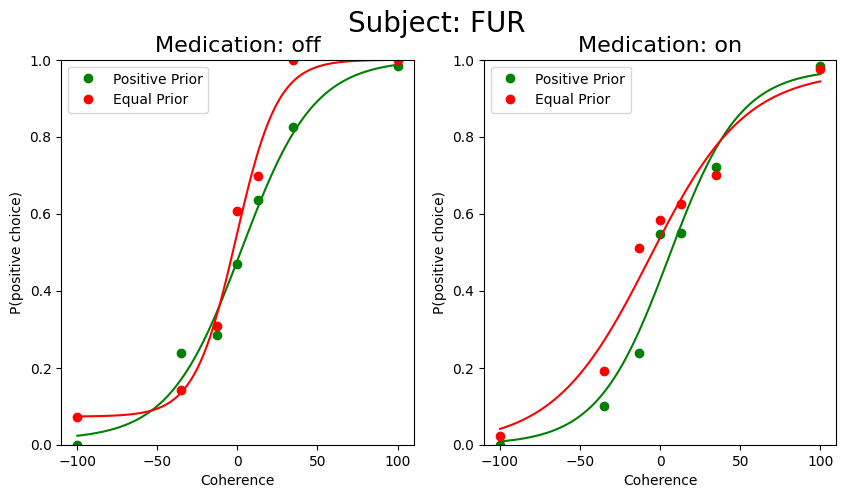

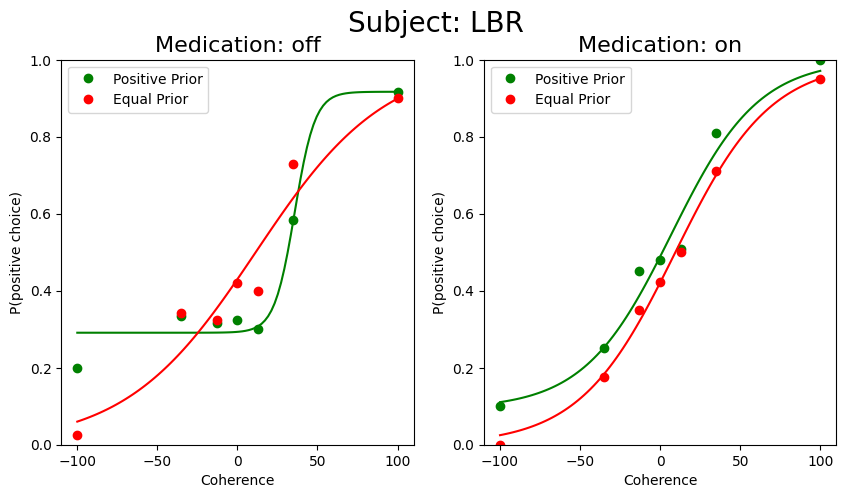

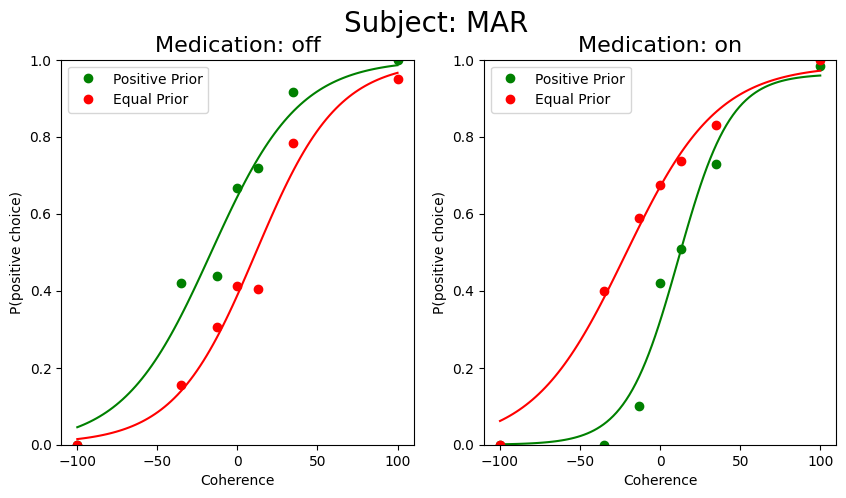

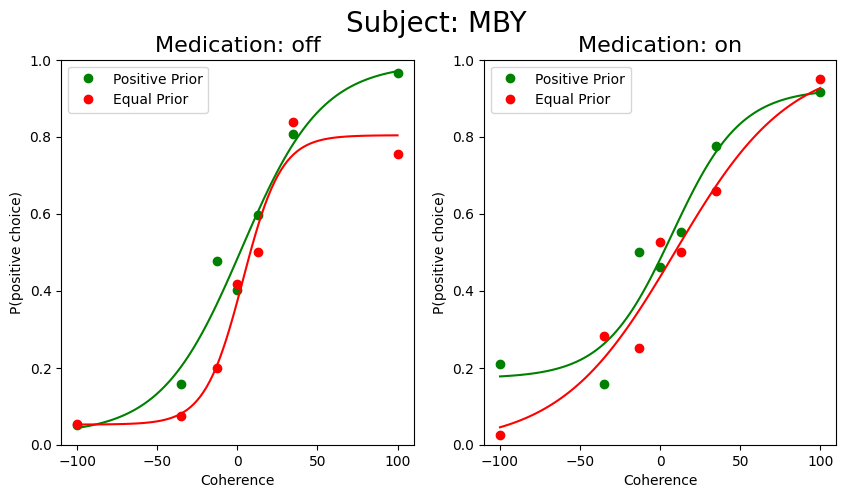

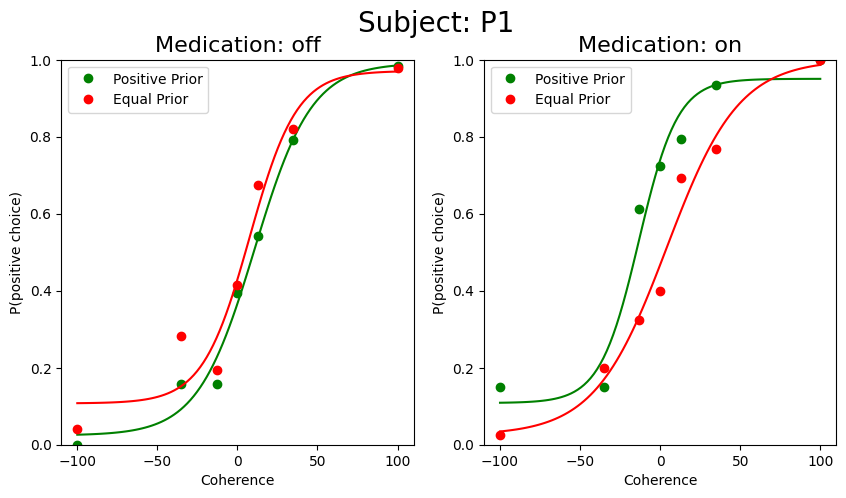

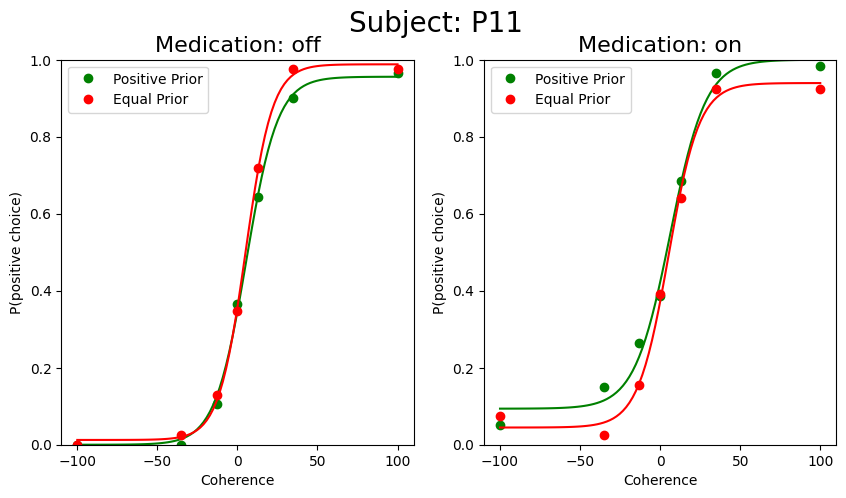

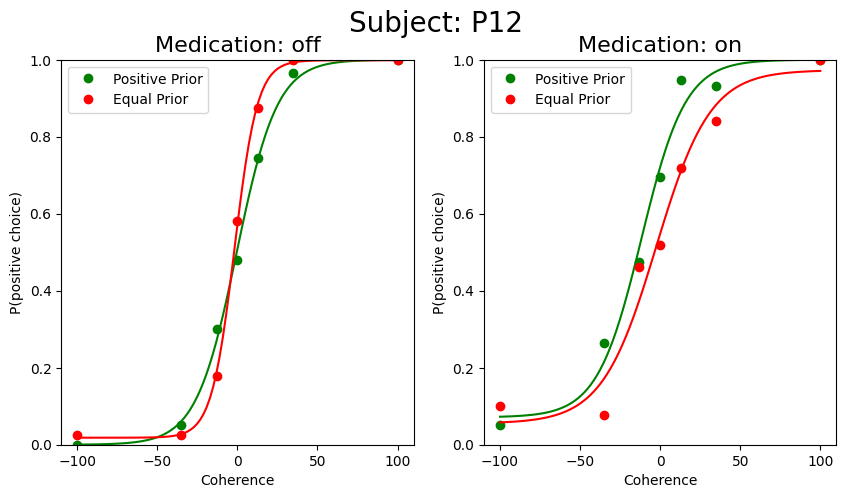

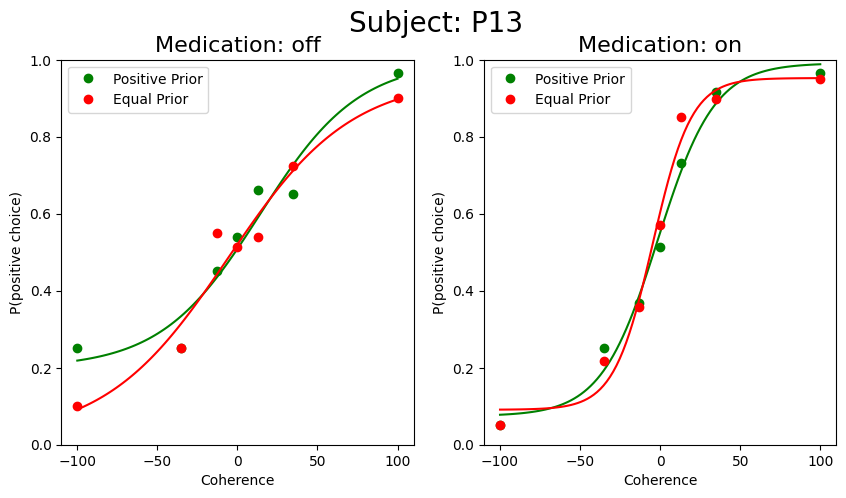

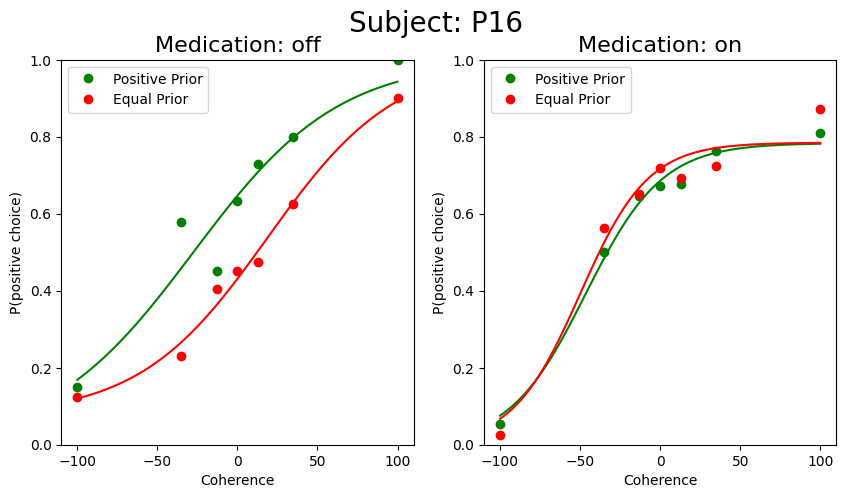

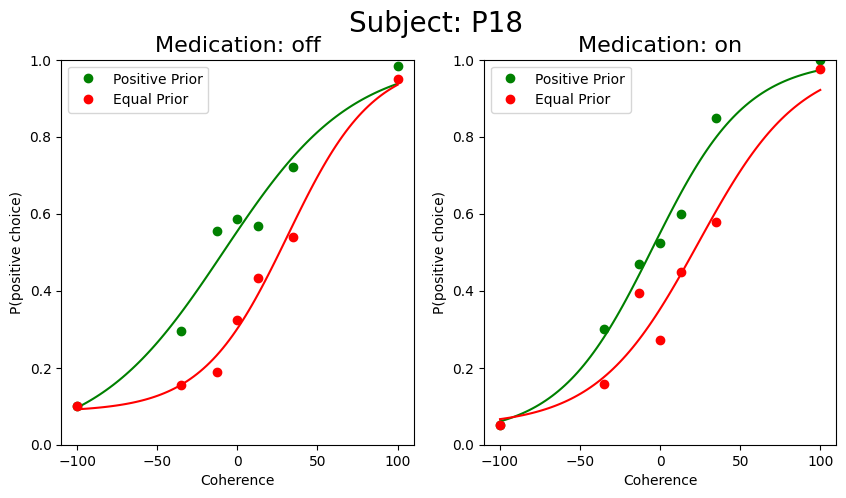

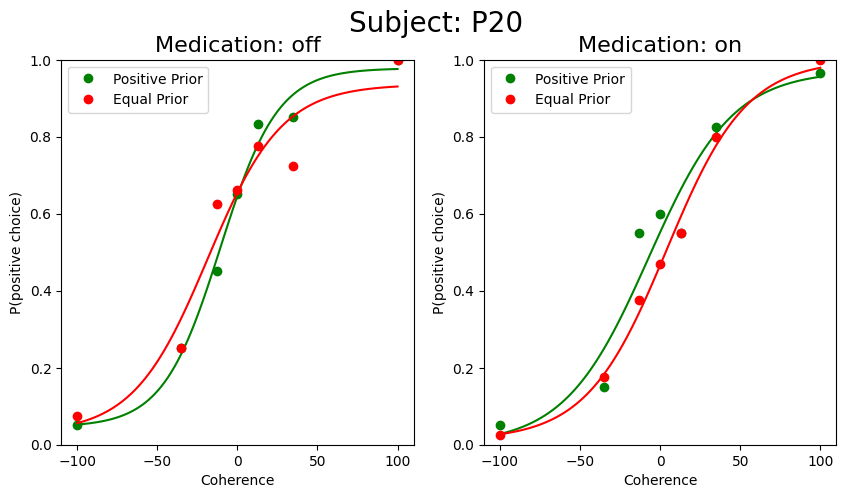

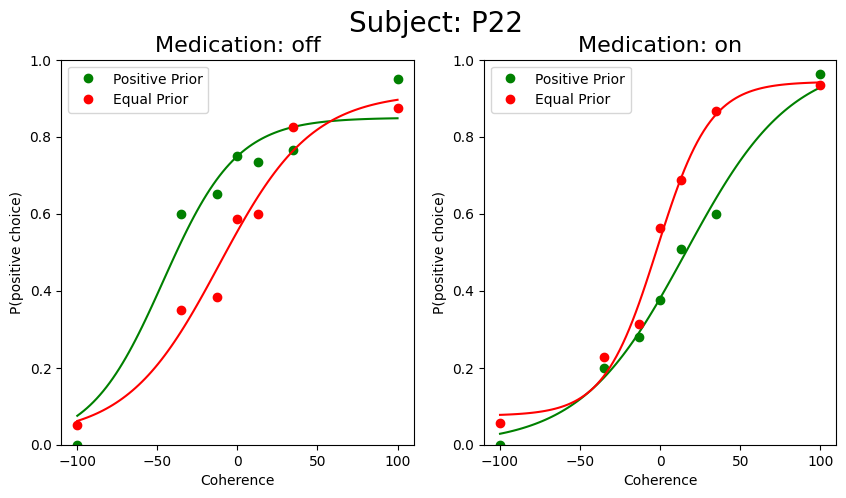

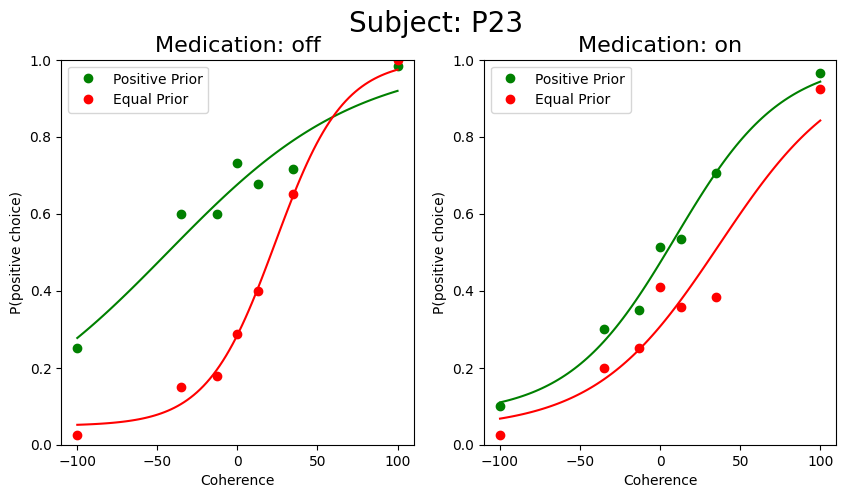

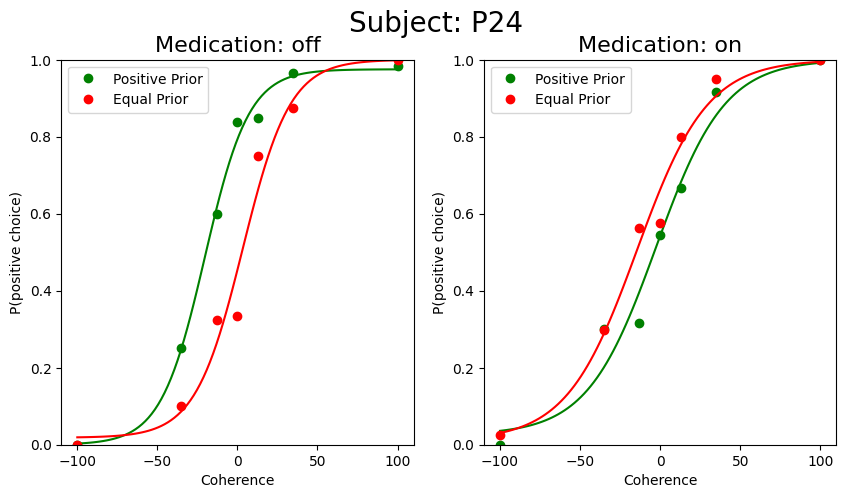

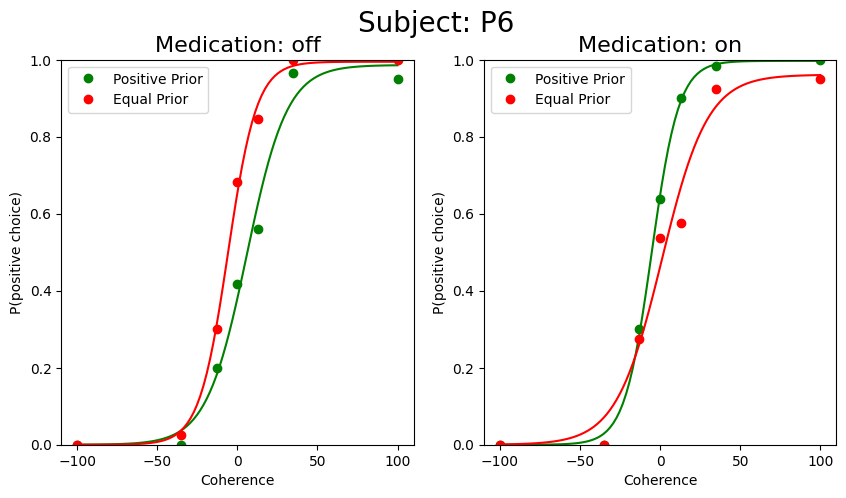

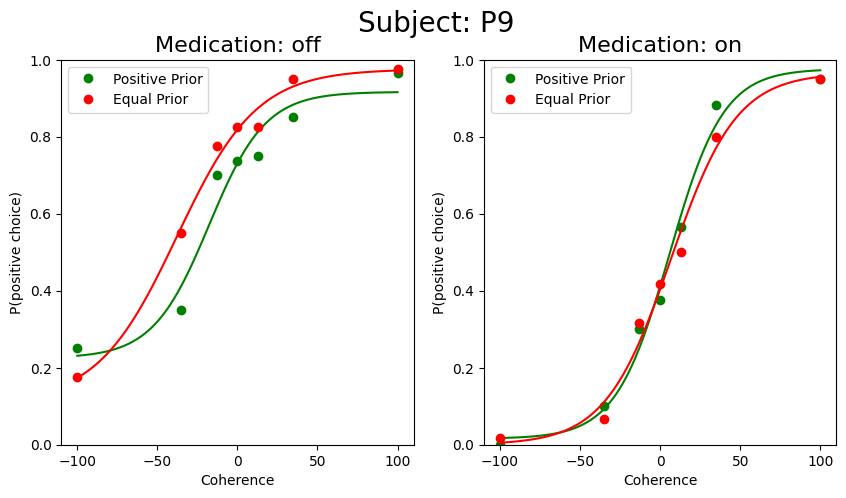

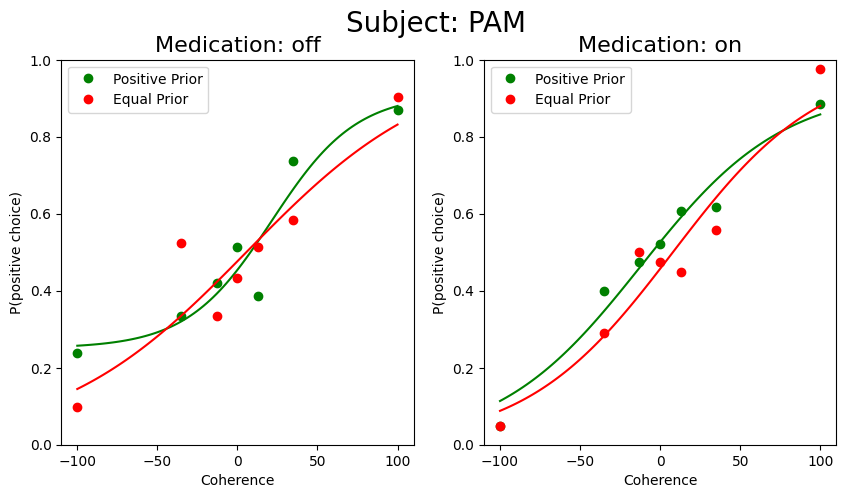

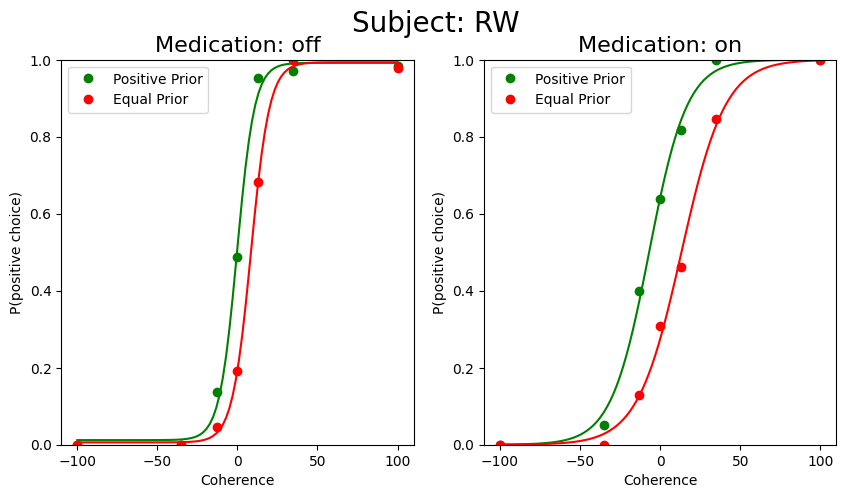

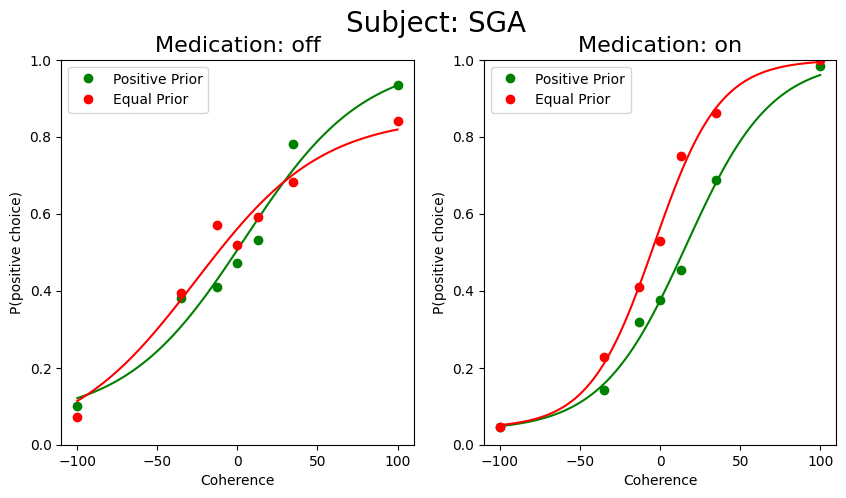

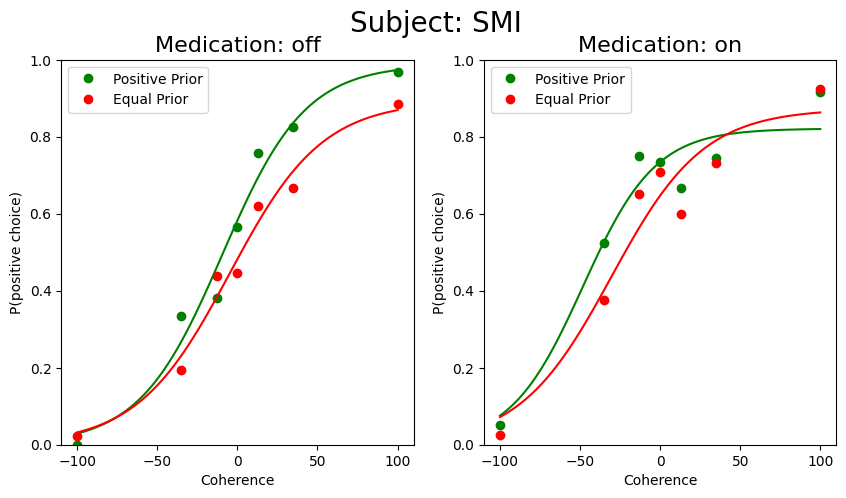

In [14]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors


for i, subject in enumerate(valid_subjects):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')
    
    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        coh, psych, model, x_hat, y_hat = utils.get_psychometric_data(med_data[med_data['color'] == 1])
        ax[idx].plot(coh, psych, 'go', label='Positive Prior')
        ax[idx].plot(x_hat, y_hat, 'g-')
        coh, psych, model, x_hat, y_hat = utils.get_psychometric_data(med_data[med_data['color'] == -1])
        ax[idx].plot(coh, psych, 'ro', label='Equal Prior')
        ax[idx].plot(x_hat, y_hat, 'r-')
        ax[idx].set_title(f"Medication: {med}", fontsize=16)
        ax[idx].set_xlabel('Coherence')
        ax[idx].set_ylabel('P(positive choice)')
        ax[idx].legend()
        ax[idx].set_ylim(0, 1)
        
    fig.suptitle(f"Subject: {subject}", fontsize=20)